Este es el primer intento en usar una red neuronal en Keras con todos los datos de `train`

In [2]:
%matplotlib inline

import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)
plt.rcParams['figure.figsize'] = (15, 6)

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Activation, Dropout, Flatten, GRU
from keras import regularizers 
import keras
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler

In [151]:
train = pd.read_csv('data/nuevo_train.csv', index_col=0, parse_dates=['timestamp'])

In [154]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509376 entries, 103088 to 103582
Data columns (total 26 columns):
timestamp               509376 non-null datetime64[ns]
consumption             509376 non-null float64
temperature             280687 non-null float64
monday_is_day_off       509376 non-null int64
tuesday_is_day_off      509376 non-null int64
wednesday_is_day_off    509376 non-null int64
thursday_is_day_off     509376 non-null int64
friday_is_day_off       509376 non-null int64
saturday_is_day_off     509376 non-null int64
sunday_is_day_off       509376 non-null int64
large                   509376 non-null int64
medium                  509376 non-null int64
small                   509376 non-null int64
x-large                 509376 non-null int64
x-small                 509376 non-null int64
xx-large                509376 non-null int64
xx-small                509376 non-null int64
high                    509376 non-null int64
low                     509376 non-null int

In [165]:
train.drop(['temperature'], axis=1, inplace=True)

In [166]:
indices = train.index.unique().values
indices.sort()

In [167]:
train.head(10)

,timestamp,consumption,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,large,...,xx-small,high,low,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
series_id,,,,,,,,,,,,,,,,,,,,,
103088,2014-12-24 00:00:00,101842.233424,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 01:00:00,105878.048906,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 02:00:00,91619.105008,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 03:00:00,94473.706203,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 04:00:00,96976.755526,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 05:00:00,109154.512346,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 06:00:00,91909.721222,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 07:00:00,100895.387051,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 08:00:00,99821.982004,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1


Transforma `consumption` de cada `series_id` en logaritmo natural y luego los normaliza

In [241]:
for ind in indices:
    valores = train.loc[ind]['consumption'].values
    valores = np.log1p(valores)
    valores_scaled = MinMaxScaler(feature_range=(-1, 1))
    valores = valores_scaled.fit_transform(valores.reshape(-1, 1))
    train.loc[ind, 'consumption'] = valores

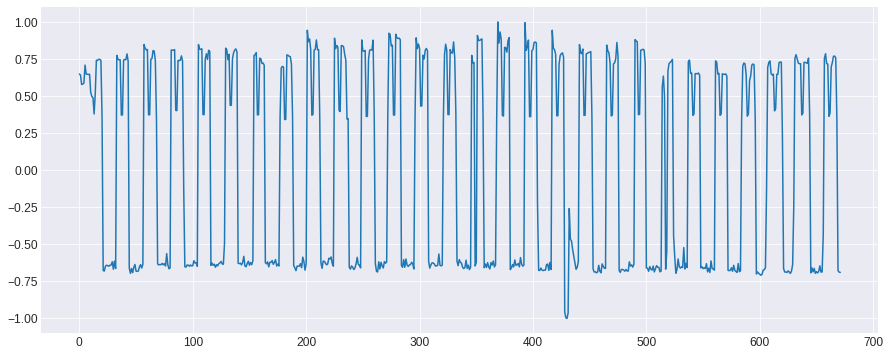

In [322]:
plt.figure(figsize=(15,6))
plt.plot(train.loc[indices[40],'consumption'].values)
plt.show()

In [10]:
split = 0.9
num_train = int(len(indices) * 0.9)
num_test = len(indices) - num_train

In [11]:
indices[-num_test:]

array([103235, 103244, 103245, 103246, 103249, 103261, 103263, 103264,
       103266, 103276, 103277, 103278, 103281, 103297, 103298, 103307,
       103310, 103320, 103321, 103322, 103324, 103331, 103334, 103346,
       103349, 103370, 103373, 103378, 103391, 103397, 103408, 103411,
       103412, 103417, 103424, 103425, 103428, 103430, 103432, 103436,
       103437, 103442, 103454, 103457, 103465, 103466, 103467, 103493,
       103496, 103498, 103501, 103502, 103503, 103510, 103517, 103536,
       103544, 103560, 103561, 103568, 103570, 103577, 103582, 103583,
       103585, 103595, 103596, 103600, 103605, 103607, 103611, 103621,
       103625, 103627, 103633, 103634])

In [12]:
train_df = train.loc[indices[:num_train]].copy()
test_df = train.loc[indices[-num_test:]].copy()

train_df = train_df.set_index('timestamp')
test_df = test_df.set_index('timestamp')

In [13]:
x_data = train_df.values

In [14]:
x_data.shape

(458304, 24)

In [15]:
y_data = train_df.consumption.values
y_data = y_data.reshape(-1, 1)

In [16]:
y_data.shape

(458304, 1)

In [17]:
num_x_signals = x_data.shape[1]
print(num_x_signals)
num_y_signals = y_data.shape[1]
print(num_y_signals)

24
1


In [214]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_data[idx:idx+sequence_length]
            y_batch[i] = y_data[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [215]:
batch_size = 64
sequence_length = 24 * 7 * 1
sequence_length

168

In [238]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Aquí se define el modelo de Keras

In [323]:
def smape_error(y_true, y_pred):
    return K.mean(K.clip(K.abs(y_pred - y_true),  0.0, 1.0), axis=-1)


def get_model(num_x_signals, num_y_signals):
# Configuración del modelo

    dropout = 0.5
    regularizer = 0.00004
    main_input = Input(shape=(None, num_x_signals), dtype='float32', name='main_input')
    #     site_input = Input(shape=(num_sites,), dtype='float32', name='site_input')
    #     access_input = Input(shape=(num_accesses,), dtype='float32', name='access_input')


    x0 = main_input
    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x0)
    x = Dropout(dropout)(x)
    x = keras.layers.concatenate([x0, x])
    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),
                           gamma_regularizer=regularizers.l2(regularizer)
                          )(x)
    x = Dropout(dropout)(x)
    x = Dense(100, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = Dropout(dropout)(x)

    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = Dropout(dropout)(x)
    x = Dense(num_y_signals, activation='linear', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)

    model =  Model(inputs=[main_input], outputs=[x])
    model.compile(loss=smape_error, optimizer='adam', metrics=['accuracy'])
    return model

In [324]:
path_checkpoint = 'primer_modelo2.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [325]:
callback_early_stopping = EarlyStopping(monitor='loss',
                                        patience=3, verbose=1)

In [24]:
callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [25]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]

In [26]:
modelo2 = get_model(num_x_signals, num_y_signals)

In [27]:
# modelo2.fit_generator(generator=generator, epochs=100, steps_per_epoch=100, callbacks=callbacks, verbose=1)

In [28]:
from keras.models import load_model

modelo2 = load_model('primer_modelo.h5', custom_objects = {'smape_error': smape_error})

In [29]:
x_test = test_df.values
y_test = test_df.consumption.values

In [30]:
print('Tamaño de x_test: {}'.format(x_test.shape))
print('Tamaño de y_test: {}'.format(y_test.shape))

Tamaño de x_test: (51072, 24)
Tamaño de y_test: (51072,)


In [31]:
x_test = np.expand_dims(x_test, axis=0)
print(x_test.shape)

result = modelo2.predict(x_test)

(1, 51072, 24)


In [32]:
result.shape

(1, 51072, 1)

In [33]:
result = np.squeeze(result, axis=0)

In [34]:
result.shape

(51072, 1)

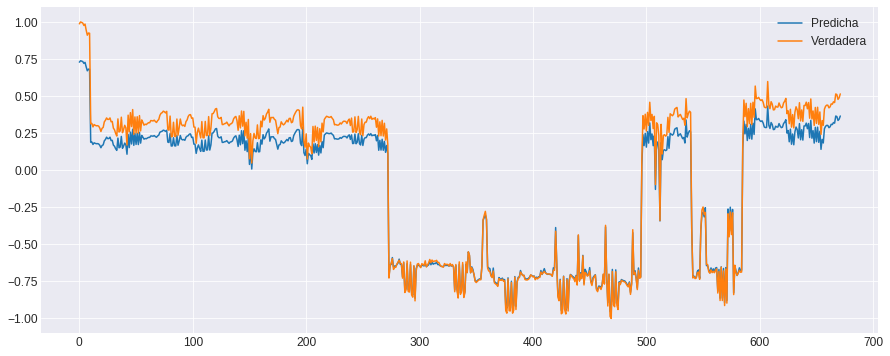

In [142]:
num_indice = 8

plt.plot(result[num_indice * 672:(num_indice + 1) * 672], label='Predicha')
plt.plot(y_test[num_indice * 672:(num_indice + 1) * 672], label='Verdadera')
plt.legend()
plt.show()

Métrica para las predicciones

In [143]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# num = 13
y_true = y_test[num_indice * 672:(num_indice + 1) * 672]
y_pred = result[num_indice * 672:(num_indice + 1) * 672]
mse = mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)
print('RMSE: {:.4}'.format(rmse))

RMSE: 0.09523


## Otro forma de predecir con el modelo de Keras construido aquí

In [155]:
train_df

,consumption,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,large,medium,...,xx-small,high,low,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-24 00:00:00,-0.926590,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 01:00:00,-0.854354,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 02:00:00,-0.926590,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 03:00:00,-0.926590,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 04:00:00,-0.854354,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 05:00:00,-0.854354,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 06:00:00,-0.926590,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 07:00:00,0.390359,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2017-10-24 08:00:00,0.224157,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [156]:
train_df.T

timestamp,2017-10-24 00:00:00,2017-10-24 01:00:00,2017-10-24 02:00:00,2017-10-24 03:00:00,2017-10-24 04:00:00,2017-10-24 05:00:00,2017-10-24 06:00:00,2017-10-24 07:00:00,2017-10-24 08:00:00,2017-10-24 09:00:00,...,2017-12-15 14:00:00,2017-12-15 15:00:00,2017-12-15 16:00:00,2017-12-15 17:00:00,2017-12-15 18:00:00,2017-12-15 19:00:00,2017-12-15 20:00:00,2017-12-15 21:00:00,2017-12-15 22:00:00,2017-12-15 23:00:00
consumption,-0.92659,-0.854354,-0.92659,-0.92659,-0.854354,-0.854354,-0.92659,0.390359,0.224157,0.90394,...,0.569552,0.592355,0.475578,0.299365,0.218681,0.134512,0.046546,0.016319,0.061485,-0.07728
monday_is_day_off,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
tuesday_is_day_off,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
wednesday_is_day_off,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
thursday_is_day_off,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
friday_is_day_off,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
saturday_is_day_off,1.00000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
sunday_is_day_off,1.00000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
large,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
medium,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [160]:
indice_train = indices[:num_train]
indice_test = indices[num_train:]

In [191]:
train

,timestamp,consumption,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,large,...,xx-small,high,low,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
series_id,,,,,,,,,,,,,,,,,,,,,
103088,2014-12-24 00:00:00,101842.233424,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 01:00:00,105878.048906,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 02:00:00,91619.105008,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 03:00:00,94473.706203,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 04:00:00,96976.755526,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 05:00:00,109154.512346,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 06:00:00,91909.721222,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 07:00:00,100895.387051,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 08:00:00,99821.982004,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1


In [188]:
def df_indice(ind, df):
    """
    Toma el indice (series_id) junto con un data frame y retorna
    el data frame con columnas timestamp con ese series_id en forma de
    numpy array
    
    """
    ind_df = df[df.index == ind]
    ind_df.set_index('timestamp', inplace=True)
    return ind_df.T.values

In [209]:
df_indice(103582, train)[:, :-40]

array([[7.09653721e+03, 6.53653195e+03, 6.56006158e+03, ...,
        6.75300457e+03, 6.48947268e+03, 6.99300682e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [326]:
tamaño_test = 24 * 7

In [327]:
tamaño_test

168

In [328]:
num_x_signals = 672 - 168

modelo3 = get_model(num_x_signals, 24)

In [329]:
path_checkpoint = 'segundo_modelo.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [330]:
callback_early_stopping = EarlyStopping(monitor='loss',
                                        patience=1, verbose=1)

In [331]:
callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [332]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]

In [317]:
for vez in range(5):
    for j in indice_train[:]:
        df_j = df_indice(j, train)
        for k, i in enumerate(reversed(range(tamaño_test))):
            extra_dim = np.expand_dims(df_j[:, k:-i-1], axis=0)
#             print(extra_dim.shape, k, i)
            modelo3.fit(extra_dim, df_j[:, -i].reshape(1, -1), epochs=5, steps_per_epoch=1, callbacks=callbacks, verbose=1)
        print(j)
    print(f'{vez}')

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.7561 - acc: 0.0833

Epoch 00001: loss improved from inf to 0.75614, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.7262 - acc: 0.0000e+00

Epoch 00002: loss improved from 0.75614 to 0.72625, saving model to segundo_modelo.h5
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.7231 - acc: 0.0417

Epoch 00003: loss improved from 0.72625 to 0.72306, saving model to segundo_modelo.h5
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.6761 - acc: 0.0833

Epoch 00004: loss improved from 0.72306 to 0.67615, saving model to segundo_modelo.h5
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 0.6595 - acc: 0.0000e+00

Epoch 00005: loss improved from 0.67615 to 0.65950, saving model to segundo_modelo.h5
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.6515 - acc: 0.0417

Epoch 00001: loss imp


Epoch 00004: loss did not improve from 0.52896
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.5648 - acc: 0.0833

Epoch 00001: loss did not improve from 0.52896
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.5532 - acc: 0.0417

Epoch 00002: loss did not improve from 0.52896
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.5591 - acc: 0.1667

Epoch 00003: loss did not improve from 0.52896
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.5601 - acc: 0.2083

Epoch 00001: loss did not improve from 0.52896
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.5293 - acc: 0.1250

Epoch 00002: loss did not improve from 0.52896
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.5518 - acc: 0.1250

Epoch 00003: loss did not improve from 0.52896
Epoch 00003: early stopping
Epoch 1/5
1/1 [=======================

Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.5096 - acc: 0.1250

Epoch 00004: loss did not improve from 0.49519
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.5076 - acc: 0.3333

Epoch 00001: loss did not improve from 0.49519
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.5121 - acc: 0.2500

Epoch 00002: loss did not improve from 0.49519
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.5053 - acc: 0.2083

Epoch 00001: loss did not improve from 0.49519
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.5250 - acc: 0.0833

Epoch 00002: loss did not improve from 0.49519
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.5162 - acc: 0.0417

Epoch 00001: loss did not improve from 0.49519
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.5404 - acc: 0.1


Epoch 00002: loss did not improve from 0.47139
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.5020 - acc: 0.1250

Epoch 00003: loss did not improve from 0.47139
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.5107 - acc: 0.2500

Epoch 00001: loss did not improve from 0.47139
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.4974 - acc: 0.1667

Epoch 00002: loss did not improve from 0.47139
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4693 - acc: 0.2083

Epoch 00003: loss improved from 0.47139 to 0.46926, saving model to segundo_modelo.h5
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4923 - acc: 0.2083

Epoch 00004: loss did not improve from 0.46926
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.4628 - acc: 0.2917

Epoch 00001: loss improved from 0.46926 to 0.46281, saving model to segundo_


Epoch 00002: loss did not improve from 0.44668
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4588 - acc: 0.3333

Epoch 00003: loss did not improve from 0.44668
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4455 - acc: 0.2917

Epoch 00001: loss improved from 0.44668 to 0.44555, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4479 - acc: 0.2083

Epoch 00002: loss did not improve from 0.44555
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4572 - acc: 0.0833

Epoch 00001: loss did not improve from 0.44555
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4650 - acc: 0.2917

Epoch 00002: loss did not improve from 0.44555
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4299 - acc: 0.2500

Epoch 00001: loss improved from 0.44555 to 0.429

Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4408 - acc: 0.2500

Epoch 00001: loss did not improve from 0.41660
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4408 - acc: 0.5417

Epoch 00002: loss did not improve from 0.41660
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4477 - acc: 0.2083

Epoch 00001: loss did not improve from 0.41660
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.4394 - acc: 0.2500

Epoch 00002: loss did not improve from 0.41660
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4480 - acc: 0.2917

Epoch 00003: loss did not improve from 0.41660
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4413 - acc: 0.2083

Epoch 00001: loss did not improve from 0.41660
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.4311 - acc: 0.41

1/1 [==============================] - 0s 9ms/step - loss: 0.4240 - acc: 0.2083

Epoch 00003: loss did not improve from 0.40175
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4284 - acc: 0.2083

Epoch 00004: loss did not improve from 0.40175
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.3979 - acc: 0.2500

Epoch 00001: loss improved from 0.40175 to 0.39786, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4040 - acc: 0.1667

Epoch 00002: loss did not improve from 0.39786
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4170 - acc: 0.1667

Epoch 00001: loss did not improve from 0.39786
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4265 - acc: 0.0833

Epoch 00002: loss did not improve from 0.39786
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/ste

1/1 [==============================] - 0s 8ms/step - loss: 0.4133 - acc: 0.4167

Epoch 00002: loss did not improve from 0.38466
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4067 - acc: 0.2500

Epoch 00003: loss did not improve from 0.38466
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4027 - acc: 0.1250

Epoch 00004: loss did not improve from 0.38466
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.4057 - acc: 0.3333

Epoch 00005: loss did not improve from 0.38466
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.4012 - acc: 0.2083

Epoch 00001: loss did not improve from 0.38466
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.4081 - acc: 0.3333

Epoch 00002: loss did not improve from 0.38466
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.4199 - acc: 0.2083

Epoch 00001: loss did not improve f

1/1 [==============================] - 0s 10ms/step - loss: 0.3926 - acc: 0.2500

Epoch 00001: loss did not improve from 0.38336
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3835 - acc: 0.3333

Epoch 00002: loss did not improve from 0.38336
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3853 - acc: 0.2083

Epoch 00003: loss did not improve from 0.38336
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3764 - acc: 0.2500

Epoch 00001: loss improved from 0.38336 to 0.37637, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3850 - acc: 0.1667

Epoch 00002: loss did not improve from 0.37637
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3740 - acc: 0.4167

Epoch 00001: loss improved from 0.37637 to 0.37405, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] 


Epoch 00003: loss did not improve from 0.37093
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3893 - acc: 0.3750

Epoch 00001: loss did not improve from 0.37093
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3921 - acc: 0.1250

Epoch 00002: loss did not improve from 0.37093
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3986 - acc: 0.1667

Epoch 00001: loss did not improve from 0.37093
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.4130 - acc: 0.4167

Epoch 00002: loss did not improve from 0.37093
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.4331 - acc: 0.3333

Epoch 00001: loss did not improve from 0.37093
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3797 - acc: 0.2917

Epoch 00002: loss did not improve from 0.37093
Epoch 3/5
1/1 [=======================


Epoch 00001: loss did not improve from 0.37093
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3803 - acc: 0.2917

Epoch 00002: loss did not improve from 0.37093
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3944 - acc: 0.3750

Epoch 00001: loss did not improve from 0.37093
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3850 - acc: 0.5833

Epoch 00002: loss did not improve from 0.37093
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.3826 - acc: 0.3750

Epoch 00003: loss did not improve from 0.37093
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3894 - acc: 0.3333

Epoch 00004: loss did not improve from 0.37093
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3818 - acc: 0.2500

Epoch 00001: loss did not improve from 0.37093
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss


Epoch 00003: loss did not improve from 0.33417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3647 - acc: 0.3333

Epoch 00004: loss did not improve from 0.33417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3709 - acc: 0.1667

Epoch 00001: loss did not improve from 0.33417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3735 - acc: 0.4167

Epoch 00002: loss did not improve from 0.33417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3779 - acc: 0.3333

Epoch 00001: loss did not improve from 0.33417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3829 - acc: 0.2500

Epoch 00002: loss did not improve from 0.33417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3660 - acc: 0.3333

Epoch 00001: loss did not improve from 0.33417
Epoch 2/5
1/1 [=========================

1/1 [==============================] - 0s 8ms/step - loss: 0.3489 - acc: 0.3333

Epoch 00002: loss did not improve from 0.33417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3424 - acc: 0.5000

Epoch 00003: loss did not improve from 0.33417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3635 - acc: 0.2500

Epoch 00004: loss did not improve from 0.33417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3482 - acc: 0.5000

Epoch 00001: loss did not improve from 0.33417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3353 - acc: 0.2500

Epoch 00002: loss did not improve from 0.33417
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.3479 - acc: 0.5833

Epoch 00003: loss did not improve from 0.33417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.3450 - acc: 0.1667

Epoch 00001: loss did not improve

1/1 [==============================] - 0s 8ms/step - loss: 0.3278 - acc: 0.1667

Epoch 00003: loss did not improve from 0.30211
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 0.3433 - acc: 0.3750

Epoch 00001: loss did not improve from 0.30211
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3179 - acc: 0.3333

Epoch 00002: loss did not improve from 0.30211
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3353 - acc: 0.2917

Epoch 00003: loss did not improve from 0.30211
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3328 - acc: 0.2917

Epoch 00001: loss did not improve from 0.30211
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3364 - acc: 0.4167

Epoch 00002: loss did not improve from 0.30211
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3213 - acc: 0.4583

Epoch 


Epoch 00001: loss did not improve from 0.30211
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3281 - acc: 0.3750

Epoch 00002: loss did not improve from 0.30211
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3347 - acc: 0.3750

Epoch 00003: loss did not improve from 0.30211
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3281 - acc: 0.3750

Epoch 00001: loss did not improve from 0.30211
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3373 - acc: 0.3333

Epoch 00002: loss did not improve from 0.30211
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3194 - acc: 0.3333

Epoch 00001: loss did not improve from 0.30211
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3397 - acc: 0.5000

Epoch 00002: loss did not improve from 0.30211
Epoch 00002: early stopping
Epoch 1/5
1/1 [========================

1/1 [==============================] - 0s 8ms/step - loss: 0.3231 - acc: 0.4167

Epoch 00001: loss did not improve from 0.30211
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3180 - acc: 0.5000

Epoch 00002: loss did not improve from 0.30211
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.2971 - acc: 0.3750

Epoch 00003: loss improved from 0.30211 to 0.29708, saving model to segundo_modelo.h5
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3216 - acc: 0.4583

Epoch 00004: loss did not improve from 0.29708
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3264 - acc: 0.2917

Epoch 00001: loss did not improve from 0.29708
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3044 - acc: 0.2500

Epoch 00002: loss did not improve from 0.29708
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3198 - acc: 0.2500

Epoch 00003: loss did 

1/1 [==============================] - 0s 8ms/step - loss: 0.3162 - acc: 0.2083

Epoch 00001: loss did not improve from 0.29708
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3252 - acc: 0.3750

Epoch 00002: loss did not improve from 0.29708
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3406 - acc: 0.1250

Epoch 00001: loss did not improve from 0.29708
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3245 - acc: 0.4167

Epoch 00002: loss did not improve from 0.29708
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3146 - acc: 0.1667

Epoch 00003: loss did not improve from 0.29708
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3330 - acc: 0.5000

Epoch 00004: loss did not improve from 0.29708
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3373 - acc: 0.3333

Epoch 00001: loss did not improve f


Epoch 00003: loss did not improve from 0.28602
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3269 - acc: 0.4167

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3332 - acc: 0.2917

Epoch 00002: loss did not improve from 0.28602
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3266 - acc: 0.4167

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3197 - acc: 0.4583

Epoch 00002: loss did not improve from 0.28602
Epoch 3/5
1/1 [==============================] - 0s 13ms/step - loss: 0.3418 - acc: 0.4167

Epoch 00003: loss did not improve from 0.28602
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3251 - acc: 0.4167

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [========================


Epoch 00002: loss did not improve from 0.28602
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3246 - acc: 0.2917

Epoch 00003: loss did not improve from 0.28602
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3260 - acc: 0.4167

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3470 - acc: 0.1250

Epoch 00002: loss did not improve from 0.28602
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3367 - acc: 0.4167

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3392 - acc: 0.2917

Epoch 00002: loss did not improve from 0.28602
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.3222 - acc: 0.3333

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [========================

Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3298 - acc: 0.2083

Epoch 00002: loss did not improve from 0.28602
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3475 - acc: 0.2500

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3475 - acc: 0.5833

Epoch 00002: loss did not improve from 0.28602
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3548 - acc: 0.2083

Epoch 00001: loss did not improve from 0.28602
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3413 - acc: 0.4167

Epoch 00002: loss did not improve from 0.28602
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3342 - acc: 0.2917

Epoch 00003: loss did not improve from 0.28602
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3624 - acc: 0.4583

Epoch 00004: loss did n


Epoch 00001: loss did not improve from 0.27744
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3397 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27744
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3179 - acc: 0.3333

Epoch 00001: loss did not improve from 0.27744
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3189 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27744
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3184 - acc: 0.5000

Epoch 00001: loss did not improve from 0.27744
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3125 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27744
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3292 - acc: 0.2500

Epoch 00003: loss did not improve from 0.27744
Epoch 00003: early stopping
Epoch 1/5
1/1 [========================

1/1 [==============================] - 0s 10ms/step - loss: 0.2907 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27619
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3125 - acc: 0.4583

Epoch 00003: loss did not improve from 0.27619
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3059 - acc: 0.2917

Epoch 00001: loss did not improve from 0.27619
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3070 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27619
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2984 - acc: 0.4167

Epoch 00001: loss did not improve from 0.27619
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.3164 - acc: 0.5000

Epoch 00002: loss did not improve from 0.27619
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3124 - acc: 0.2083

Epoch


Epoch 00002: loss did not improve from 0.27619
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3190 - acc: 0.2917

Epoch 00003: loss did not improve from 0.27619
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3066 - acc: 0.4583

Epoch 00001: loss did not improve from 0.27619
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2870 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27619
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2932 - acc: 0.4167

Epoch 00003: loss did not improve from 0.27619
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2956 - acc: 0.4167

Epoch 00001: loss did not improve from 0.27619
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2966 - acc: 0.3333

Epoch 00002: loss did not improve from 0.27619
Epoch 00002: early stopping
Epoch 1/5
1/1 [=========================


Epoch 00001: loss did not improve from 0.27619
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3104 - acc: 0.3750

Epoch 00002: loss did not improve from 0.27619
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3013 - acc: 0.3750

Epoch 00003: loss did not improve from 0.27619
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3001 - acc: 0.5833

Epoch 00004: loss did not improve from 0.27619
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3191 - acc: 0.2917

Epoch 00005: loss did not improve from 0.27619
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2945 - acc: 0.3333

Epoch 00001: loss did not improve from 0.27619
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3104 - acc: 0.3333

Epoch 00002: loss did not improve from 0.27619
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss:

Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3007 - acc: 0.3333

Epoch 00001: loss did not improve from 0.26353
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3055 - acc: 0.4167

Epoch 00002: loss did not improve from 0.26353
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2784 - acc: 0.4583

Epoch 00001: loss did not improve from 0.26353
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2978 - acc: 0.2500

Epoch 00002: loss did not improve from 0.26353
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2901 - acc: 0.2917

Epoch 00001: loss did not improve from 0.26353
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2767 - acc: 0.2500

Epoch 00002: loss did not improve from 0.26353
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2884 - acc: 0.291

Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.3129 - acc: 0.2917

Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3622 - acc: 0.1250

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3539 - acc: 0.2917

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3575 - acc: 0.5000

Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3473 - acc: 0.2500

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 13ms/step - loss: 0.3489 - acc: 0.2500

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3566 - acc: 0.25


Epoch 00003: loss did not improve from 0.25692
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 0.3097 - acc: 0.4583

Epoch 00004: loss did not improve from 0.25692
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3287 - acc: 0.2917

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3099 - acc: 0.5000

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3305 - acc: 0.4583

Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3484 - acc: 0.3750

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3426 - acc: 0.4583

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss


Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2959 - acc: 0.5000

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3071 - acc: 0.3750

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3239 - acc: 0.4583

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2893 - acc: 0.3333

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.3124 - acc: 0.3750

Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3308 - acc: 0.1250

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [========================


Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3126 - acc: 0.2500

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2953 - acc: 0.3750

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3023 - acc: 0.4167

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3018 - acc: 0.4167

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3219 - acc: 0.2500

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3071 - acc: 0.3333

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [=========================

1/1 [==============================] - 0s 8ms/step - loss: 0.2892 - acc: 0.4167

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3067 - acc: 0.5000

Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3070 - acc: 0.2917

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.3130 - acc: 0.3333

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.2758 - acc: 0.3333

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3052 - acc: 0.4583

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2972 - acc: 0.3333

Epoch

1/1 [==============================] - 0s 7ms/step - loss: 0.3149 - acc: 0.3333

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2863 - acc: 0.5000

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2904 - acc: 0.4167

Epoch 00003: loss did not improve from 0.25692
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3090 - acc: 0.4583

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.3146 - acc: 0.2500

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.3084 - acc: 0.3333

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.3058 - acc: 0.1250

Epoch 00002: loss did not improve f


Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2666 - acc: 0.4167

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2872 - acc: 0.3750

Epoch 00002: loss did not improve from 0.25692
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2877 - acc: 0.3750

Epoch 00001: loss did not improve from 0.25692
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2822 - acc: 0.4583

Epoch 00002: loss did not improve from 0.25692
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2816 - acc: 0.2083

Epoch 00003: loss did not improve from 0.25692
Epoch 4/5
1/1 [==============================] - 0s 12ms/step - loss: 0.2878 - acc: 0.3750

Epoch 00004: loss did not improve from 0.25692
Epoch 00004: early stopping
Epoch 1/5
1/1 [========================

1/1 [==============================] - 0s 8ms/step - loss: 0.3005 - acc: 0.3333

Epoch 00004: loss did not improve from 0.25396
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2914 - acc: 0.2917

Epoch 00001: loss did not improve from 0.25396
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2877 - acc: 0.4167

Epoch 00002: loss did not improve from 0.25396
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2712 - acc: 0.2917

Epoch 00003: loss did not improve from 0.25396
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2862 - acc: 0.5000

Epoch 00004: loss did not improve from 0.25396
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2839 - acc: 0.3333

Epoch 00001: loss did not improve from 0.25396
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2837 - acc: 0.2917

Epoch 00002: loss did not improve


Epoch 00003: loss did not improve from 0.25132
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2508 - acc: 0.2917

Epoch 00001: loss improved from 0.25132 to 0.25077, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2459 - acc: 0.2500

Epoch 00002: loss improved from 0.25077 to 0.24588, saving model to segundo_modelo.h5
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2566 - acc: 0.3333

Epoch 00003: loss did not improve from 0.24588
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2716 - acc: 0.3333

Epoch 00001: loss did not improve from 0.24588
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2661 - acc: 0.3750

Epoch 00002: loss did not improve from 0.24588
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2856 - acc: 0.2083

Epoch 00003: loss did not improve fro


Epoch 00004: loss did not improve from 0.22029
Epoch 5/5
1/1 [==============================] - 0s 12ms/step - loss: 0.2403 - acc: 0.5417

Epoch 00005: loss did not improve from 0.22029
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2620 - acc: 0.2917

Epoch 00001: loss did not improve from 0.22029
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2714 - acc: 0.5417

Epoch 00002: loss did not improve from 0.22029
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2740 - acc: 0.5833

Epoch 00001: loss did not improve from 0.22029
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2678 - acc: 0.3750

Epoch 00002: loss did not improve from 0.22029
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.2619 - acc: 0.2500

Epoch 00003: loss did not improve from 0.22029
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - los


Epoch 00001: loss did not improve from 0.21955
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2359 - acc: 0.3750

Epoch 00002: loss did not improve from 0.21955
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2277 - acc: 0.5833

Epoch 00003: loss did not improve from 0.21955
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2264 - acc: 0.3750

Epoch 00004: loss did not improve from 0.21955
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2273 - acc: 0.4583

Epoch 00005: loss did not improve from 0.21955
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2319 - acc: 0.2500

Epoch 00001: loss did not improve from 0.21955
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2286 - acc: 0.3333

Epoch 00002: loss did not improve from 0.21955
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2280 - acc: 0.2083

Epoch


Epoch 00004: loss did not improve from 0.21669
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2232 - acc: 0.3333

Epoch 00005: loss did not improve from 0.21669
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2122 - acc: 0.4583

Epoch 00001: loss improved from 0.21669 to 0.21216, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2150 - acc: 0.6250

Epoch 00002: loss did not improve from 0.21216
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2147 - acc: 0.3750

Epoch 00001: loss did not improve from 0.21216
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2003 - acc: 0.2917

Epoch 00002: loss improved from 0.21216 to 0.20031, saving model to segundo_modelo.h5
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2160 - acc: 0.3333

Epoch 00003: loss did not improve fro


Epoch 00004: loss did not improve from 0.20031
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2178 - acc: 0.2500

Epoch 00001: loss did not improve from 0.20031
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2199 - acc: 0.3333

Epoch 00002: loss did not improve from 0.20031
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2197 - acc: 0.4583

Epoch 00001: loss did not improve from 0.20031
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2147 - acc: 0.3333

Epoch 00002: loss did not improve from 0.20031
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2117 - acc: 0.3333

Epoch 00003: loss did not improve from 0.20031
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2088 - acc: 0.4167

Epoch 00004: loss did not improve from 0.20031
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss


Epoch 00003: loss did not improve from 0.19391
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2171 - acc: 0.1667

Epoch 00001: loss did not improve from 0.19391
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2147 - acc: 0.2917

Epoch 00002: loss did not improve from 0.19391
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2167 - acc: 0.5000

Epoch 00003: loss did not improve from 0.19391
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2086 - acc: 0.3333

Epoch 00001: loss did not improve from 0.19391
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2114 - acc: 0.2917

Epoch 00002: loss did not improve from 0.19391
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2122 - acc: 0.5417

Epoch 00001: loss did not improve from 0.19391
Epoch 2/5
1/1 [=========================


Epoch 00003: loss did not improve from 0.19391
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2198 - acc: 0.3333

Epoch 00001: loss did not improve from 0.19391
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2202 - acc: 0.4167

Epoch 00002: loss did not improve from 0.19391
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2085 - acc: 0.3750

Epoch 00001: loss did not improve from 0.19391
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2071 - acc: 0.2083

Epoch 00002: loss did not improve from 0.19391
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2274 - acc: 0.1250

Epoch 00003: loss did not improve from 0.19391
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2180 - acc: 0.2917

Epoch 00001: loss did not improve from 0.19391
Epoch 2/5
1/1 [=========================


Epoch 00003: loss did not improve from 0.18403
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2116 - acc: 0.2083

Epoch 00001: loss did not improve from 0.18403
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2226 - acc: 0.2500

Epoch 00002: loss did not improve from 0.18403
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2154 - acc: 0.3333

Epoch 00001: loss did not improve from 0.18403
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2174 - acc: 0.4583

Epoch 00002: loss did not improve from 0.18403
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2001 - acc: 0.3750

Epoch 00001: loss did not improve from 0.18403
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.2008 - acc: 0.2083

Epoch 00002: loss did not improve from 0.18403
Epoch 00002: early stopping
Epoch 1/5
1


Epoch 00001: loss did not improve from 0.17037
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1865 - acc: 0.2500

Epoch 00002: loss did not improve from 0.17037
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2161 - acc: 0.3750

Epoch 00001: loss did not improve from 0.17037
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2145 - acc: 0.2500

Epoch 00002: loss did not improve from 0.17037
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2083 - acc: 0.3750

Epoch 00003: loss did not improve from 0.17037
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2035 - acc: 0.4167

Epoch 00004: loss did not improve from 0.17037
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1899 - acc: 0.2500

Epoch 00005: loss did not improve from 0.17037
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1872 - acc: 0.3750

Epoch


Epoch 00002: loss did not improve from 0.16746
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1984 - acc: 0.3333

Epoch 00003: loss did not improve from 0.16746
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1942 - acc: 0.2083

Epoch 00001: loss did not improve from 0.16746
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1916 - acc: 0.4583

Epoch 00002: loss did not improve from 0.16746
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1900 - acc: 0.3333

Epoch 00003: loss did not improve from 0.16746
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1855 - acc: 0.4167

Epoch 00004: loss did not improve from 0.16746
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1865 - acc: 0.2500

Epoch 00005: loss did not improve from 0.16746
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss:

1/1 [==============================] - 0s 7ms/step - loss: 0.1980 - acc: 0.4167

Epoch 00002: loss did not improve from 0.16746
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1785 - acc: 0.5417

Epoch 00001: loss did not improve from 0.16746
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2048 - acc: 0.4583

Epoch 00002: loss did not improve from 0.16746
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1974 - acc: 0.3333

Epoch 00001: loss did not improve from 0.16746
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1974 - acc: 0.3750

Epoch 00002: loss did not improve from 0.16746
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1882 - acc: 0.2500

Epoch 00001: loss did not improve from 0.16746
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1812 - acc: 0.5000

Epoch 

1/1 [==============================] - 0s 8ms/step - loss: 0.1773 - acc: 0.4167

Epoch 00002: loss did not improve from 0.16366
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1700 - acc: 0.2083

Epoch 00003: loss did not improve from 0.16366
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1920 - acc: 0.4167

Epoch 00004: loss did not improve from 0.16366
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1969 - acc: 0.2917

Epoch 00001: loss did not improve from 0.16366
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1850 - acc: 0.4167

Epoch 00002: loss did not improve from 0.16366
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1797 - acc: 0.4167

Epoch 00003: loss did not improve from 0.16366
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1839 - acc: 0.3750

Epoch 00004: loss did not improve from 0.16366
Epoch 00004: 


Epoch 00003: loss did not improve from 0.16366
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1629 - acc: 0.3750

Epoch 00004: loss improved from 0.16366 to 0.16294, saving model to segundo_modelo.h5
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1724 - acc: 0.2083

Epoch 00005: loss did not improve from 0.16294
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1745 - acc: 0.4167

Epoch 00001: loss did not improve from 0.16294
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1773 - acc: 0.3750

Epoch 00002: loss did not improve from 0.16294
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1678 - acc: 0.3750

Epoch 00001: loss did not improve from 0.16294
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1833 - acc: 0.1250

Epoch 00002: loss did not improve from 0.16294
Epoch 00002: early stopping
E


Epoch 00002: loss did not improve from 0.15566
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1808 - acc: 0.3333

Epoch 00001: loss did not improve from 0.15566
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1776 - acc: 0.4167

Epoch 00002: loss did not improve from 0.15566
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1794 - acc: 0.2083

Epoch 00003: loss did not improve from 0.15566
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1662 - acc: 0.2917

Epoch 00001: loss did not improve from 0.15566
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1836 - acc: 0.4167

Epoch 00002: loss did not improve from 0.15566
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1887 - acc: 0.5000

Epoch 00001: loss did not improve from 0.15566
Epoch 2/5
1/1 [========================

1/1 [==============================] - 0s 7ms/step - loss: 0.1886 - acc: 0.4583

Epoch 00002: loss did not improve from 0.15566
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1802 - acc: 0.3333

Epoch 00003: loss did not improve from 0.15566
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1880 - acc: 0.3333

Epoch 00004: loss did not improve from 0.15566
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1814 - acc: 0.2500

Epoch 00001: loss did not improve from 0.15566
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1791 - acc: 0.4167

Epoch 00002: loss did not improve from 0.15566
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1789 - acc: 0.4583

Epoch 00003: loss did not improve from 0.15566
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1708 - acc: 0.2083

Epoch 00004: loss did not improve from 0.15566
Epoch 5/5
1/1 [=


Epoch 00001: loss did not improve from 0.15245
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1554 - acc: 0.5833

Epoch 00002: loss did not improve from 0.15245
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1758 - acc: 0.2917

Epoch 00003: loss did not improve from 0.15245
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1486 - acc: 0.3333

Epoch 00001: loss improved from 0.15245 to 0.14864, saving model to segundo_modelo.h5
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1796 - acc: 0.2083

Epoch 00002: loss did not improve from 0.14864
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1739 - acc: 0.6250

Epoch 00001: loss did not improve from 0.14864
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1716 - acc: 0.4167

Epoch 00002: loss did not improve from 0.14864
Epoch 3/5
1/1 [==============


Epoch 00003: loss did not improve from 0.14543
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1723 - acc: 0.1667

Epoch 00001: loss did not improve from 0.14543
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1415 - acc: 0.2500

Epoch 00002: loss improved from 0.14543 to 0.14147, saving model to segundo_modelo.h5
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1585 - acc: 0.3750

Epoch 00003: loss did not improve from 0.14147
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1716 - acc: 0.3333

Epoch 00001: loss did not improve from 0.14147
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1627 - acc: 0.3750

Epoch 00002: loss did not improve from 0.14147
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1507 - acc: 0.4583

Epoch 00003: loss did not improve from 0.14147
Epoch 4/5
1/1 [===========

Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1672 - acc: 0.3333

Epoch 00004: loss did not improve from 0.13839
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1635 - acc: 0.5000

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1458 - acc: 0.3333

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1579 - acc: 0.2917

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1624 - acc: 0.4167

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1439 - acc: 0.4167

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1551 - acc: 0.4583

Epoch 00003: loss did not


Epoch 00002: loss did not improve from 0.13839
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1797 - acc: 0.2917

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1731 - acc: 0.3333

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1851 - acc: 0.2917

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1835 - acc: 0.6250

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1701 - acc: 0.3333

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2066 - acc: 0.5000

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [=========================

Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1815 - acc: 0.5000

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1697 - acc: 0.4583

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1720 - acc: 0.4167

Epoch 00002: loss did not improve from 0.13839
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1809 - acc: 0.4167

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1675 - acc: 0.3333

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1808 - acc: 0.3750

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1692 - acc: 0.375

1/1 [==============================] - 0s 7ms/step - loss: 0.1791 - acc: 0.2500

Epoch 00002: loss did not improve from 0.13839
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1733 - acc: 0.5000

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1774 - acc: 0.3333

Epoch 00002: loss did not improve from 0.13839
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1740 - acc: 0.2917

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1621 - acc: 0.4583

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1644 - acc: 0.5417

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1743 - acc: 0.2083

Epoch 0


Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1452 - acc: 0.2917

Epoch 00002: loss did not improve from 0.13839
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1503 - acc: 0.2083

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1456 - acc: 0.5000

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1408 - acc: 0.2917

Epoch 00003: loss did not improve from 0.13839
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1560 - acc: 0.3333

Epoch 00004: loss did not improve from 0.13839
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1679 - acc: 0.1667

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - los

1/1 [==============================] - 0s 7ms/step - loss: 0.1622 - acc: 0.2500

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1652 - acc: 0.3750

Epoch 00003: loss did not improve from 0.13839
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1710 - acc: 0.4167

Epoch 00001: loss did not improve from 0.13839
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1665 - acc: 0.3750

Epoch 00002: loss did not improve from 0.13839
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1659 - acc: 0.4167

Epoch 00003: loss did not improve from 0.13839
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1645 - acc: 0.3750

Epoch 00004: loss did not improve from 0.13839
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1567 - acc: 0.5000

Epoch 00005: loss did not improve from 0.13839
Epoch 1/5
1/1 [


Epoch 00003: loss did not improve from 0.13772
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1574 - acc: 0.2917

Epoch 00001: loss did not improve from 0.13772
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1697 - acc: 0.3750

Epoch 00002: loss did not improve from 0.13772
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1589 - acc: 0.1667

Epoch 00001: loss did not improve from 0.13772
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1633 - acc: 0.4167

Epoch 00002: loss did not improve from 0.13772
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1719 - acc: 0.2500

Epoch 00001: loss did not improve from 0.13772
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1698 - acc: 0.3750

Epoch 00002: loss did not improve from 0.13772
Epoch 3/5
1/1 [=========================


Epoch 00004: loss did not improve from 0.13772
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1665 - acc: 0.4167

Epoch 00001: loss did not improve from 0.13772
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1602 - acc: 0.3333

Epoch 00002: loss did not improve from 0.13772
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1574 - acc: 0.3333

Epoch 00003: loss did not improve from 0.13772
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1632 - acc: 0.4167

Epoch 00004: loss did not improve from 0.13772
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1674 - acc: 0.3333

Epoch 00001: loss did not improve from 0.13772
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1656 - acc: 0.2917

Epoch 00002: loss did not improve from 0.13772
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - los


Epoch 00001: loss did not improve from 0.12678
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1566 - acc: 0.2083

Epoch 00002: loss did not improve from 0.12678
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1551 - acc: 0.2917

Epoch 00003: loss did not improve from 0.12678
Epoch 4/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1631 - acc: 0.3750

Epoch 00004: loss did not improve from 0.12678
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1574 - acc: 0.3750

Epoch 00001: loss did not improve from 0.12678
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1568 - acc: 0.2083

Epoch 00002: loss did not improve from 0.12678
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1612 - acc: 0.3333

Epoch 00003: loss did not improve from 0.12678
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - los

1/1 [==============================] - 0s 9ms/step - loss: 0.1425 - acc: 0.3333

Epoch 00002: loss did not improve from 0.12078
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1384 - acc: 0.3750

Epoch 00001: loss did not improve from 0.12078
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1289 - acc: 0.4583

Epoch 00002: loss did not improve from 0.12078
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1371 - acc: 0.3333

Epoch 00003: loss did not improve from 0.12078
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1378 - acc: 0.4167

Epoch 00001: loss did not improve from 0.12078
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1592 - acc: 0.3750

Epoch 00002: loss did not improve from 0.12078
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 14ms/step - loss: 0.1373 - acc: 0.2917

Epoch 

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1298 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1387 - acc: 0.2500

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1484 - acc: 0.2500

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1359 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1368 - acc: 0.2083

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1280 - acc: 0.5000

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 

1/1 [==============================] - 0s 8ms/step - loss: 0.1425 - acc: 0.3333

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1272 - acc: 0.2500

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1245 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1393 - acc: 0.2083

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1334 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1403 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1316 - acc: 0.2500

Epoch

Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1163 - acc: 0.2917

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1145 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1251 - acc: 0.4583

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1319 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1137 - acc: 0.1250

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1234 - acc: 0.0833

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1187 - acc: 0.291


Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1263 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1322 - acc: 0.2917

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1205 - acc: 0.4167

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1169 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1148 - acc: 0.1667

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1219 - acc: 0.3333

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss:

1/1 [==============================] - 0s 9ms/step - loss: 0.1281 - acc: 0.4583

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1297 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1292 - acc: 0.4167

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1350 - acc: 0.1667

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1236 - acc: 0.0833

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1181 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1236 - acc: 0.2083

Epoch 00003: loss did not improve f


Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1406 - acc: 0.1250

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1336 - acc: 0.3333

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1308 - acc: 0.3333

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1327 - acc: 0.2500

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1356 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1368 - acc: 0.1667

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [=========================

Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1350 - acc: 0.1667

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1371 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1274 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1359 - acc: 0.3333

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1467 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1459 - acc: 0.3750

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1353 - acc: 0.166

1/1 [==============================] - 0s 8ms/step - loss: 0.2104 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2169 - acc: 0.3333

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2104 - acc: 0.3750

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2263 - acc: 0.1667

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2114 - acc: 0.4167

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2182 - acc: 0.4583

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1963 - acc: 0.2083

Epoch 

1/1 [==============================] - 0s 8ms/step - loss: 0.2223 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2174 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2210 - acc: 0.1667

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2192 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2206 - acc: 0.3333

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2154 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2245 - acc: 0.3333

Epoch 00002: loss did not improve f

1/1 [==============================] - 0s 7ms/step - loss: 0.2058 - acc: 0.1667

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2108 - acc: 0.3750

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2270 - acc: 0.1667

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2219 - acc: 0.3750

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2145 - acc: 0.3750

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2274 - acc: 0.3333

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2114 - acc: 0.4583

Epoch 00001: loss did not improve f


Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1930 - acc: 0.1667

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1887 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1807 - acc: 0.3333

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1929 - acc: 0.3333

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1919 - acc: 0.4583

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1974 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [========================


Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1925 - acc: 0.3750

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1938 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1983 - acc: 0.1667

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1870 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1913 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1952 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [=========================


Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1878 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1966 - acc: 0.5417

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1950 - acc: 0.2500

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1991 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1881 - acc: 0.3750

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1868 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss

1/1 [==============================] - 0s 7ms/step - loss: 0.1911 - acc: 0.3750

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1850 - acc: 0.4167

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1903 - acc: 0.4167

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2044 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1921 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 12ms/step - loss: 0.2000 - acc: 0.3750

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1995 - acc: 0.2083

Epoch 00001: loss did not improve

Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1872 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1878 - acc: 0.3750

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1980 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1927 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1931 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1879 - acc: 0.4583

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1859 - acc: 0.4167

Epoch 00002:


Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1769 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1423 - acc: 0.4167

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1543 - acc: 0.4167

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1534 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1539 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1658 - acc: 0.3750

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [=========================


Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1535 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1505 - acc: 0.4167

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1518 - acc: 0.2083

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1504 - acc: 0.2500

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1537 - acc: 0.4167

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1667 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [========================

1/1 [==============================] - 0s 8ms/step - loss: 0.1416 - acc: 0.3333

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1363 - acc: 0.2500

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1663 - acc: 0.3333

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1429 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1418 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1381 - acc: 0.2083

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1369 - acc: 0.2083

Epoch 00004: loss did not improve 

Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1493 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1394 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1461 - acc: 0.3333

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1446 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1407 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1453 - acc: 0.1250

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1633 - acc: 0.208


Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1510 - acc: 0.4167

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1347 - acc: 0.0833

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1430 - acc: 0.2500

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1359 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1301 - acc: 0.1667

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1239 - acc: 0.2500

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss

Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1533 - acc: 0.1667

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1556 - acc: 0.1250

Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1591 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1519 - acc: 0.3750

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1536 - acc: 0.3333

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1576 - acc: 0.2500

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1595 - acc: 0.291


Epoch 00002: loss did not improve from 0.11153
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1463 - acc: 0.3333

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1377 - acc: 0.2500

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1441 - acc: 0.2917

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1367 - acc: 0.2083

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1356 - acc: 0.2917

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1445 - acc: 0.2500

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [=========================


Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1197 - acc: 0.4583

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1208 - acc: 0.2917

Epoch 00003: loss did not improve from 0.11153
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1251 - acc: 0.2917

Epoch 00001: loss did not improve from 0.11153
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1234 - acc: 0.2083

Epoch 00002: loss did not improve from 0.11153
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1221 - acc: 0.4167

Epoch 00003: loss did not improve from 0.11153
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1355 - acc: 0.3333

Epoch 00004: loss did not improve from 0.11153
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss

1/1 [==============================] - 0s 7ms/step - loss: 0.1190 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10800
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1134 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10800
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1185 - acc: 0.4583

Epoch 00003: loss did not improve from 0.10800
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1427 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10800
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1369 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10800
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1319 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10800
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1419 - acc: 0.2083

Epoch 00004: loss did not improve from 0.10800
Epoch 00004: ear


Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1733 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1722 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1808 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1751 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1741 - acc: 0.1667

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1789 - acc: 0.4167

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [=========================


Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1970 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1990 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1970 - acc: 0.2083

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2011 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2059 - acc: 0.1667

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2023 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [=========================


Epoch 00003: loss did not improve from 0.10743
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1832 - acc: 0.5000

Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1823 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1787 - acc: 0.1250

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1847 - acc: 0.4167

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1867 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1887 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [=========================

Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1663 - acc: 0.5833

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1718 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1751 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1721 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1682 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10743
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1729 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1753 - acc: 0.33


Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1819 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1792 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1775 - acc: 0.4167

Epoch 00003: loss did not improve from 0.10743
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1782 - acc: 0.4167

Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1653 - acc: 0.4583

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1637 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss:


Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1590 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10743
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1664 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1644 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1634 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1671 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1594 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss


Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1896 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1912 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1851 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1913 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1783 - acc: 0.4583

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1830 - acc: 0.2083

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [=========================

1/1 [==============================] - 0s 9ms/step - loss: 0.1802 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1700 - acc: 0.1250

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1761 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1798 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1835 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1884 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1789 - acc: 0.2500

Epoch 0


Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1614 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1554 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1548 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1540 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10743
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1628 - acc: 0.2917

Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1598 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss

1/1 [==============================] - 0s 7ms/step - loss: 0.1599 - acc: 0.5000

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1483 - acc: 0.5000

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1446 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1484 - acc: 0.2500

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1593 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1577 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1523 - acc: 0.3750

Epoch 00003: loss did not improve 

Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1276 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1268 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1290 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1252 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1264 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1288 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1212 - acc: 0.20

1/1 [==============================] - 0s 8ms/step - loss: 0.1367 - acc: 0.4583

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1445 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1369 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1381 - acc: 0.1250

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1440 - acc: 0.2083

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1440 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1467 - acc: 0.3750

Epoch


Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1169 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1193 - acc: 0.1667

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1170 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1197 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1219 - acc: 0.1667

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1217 - acc: 0.1667

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss:


Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1163 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1189 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1155 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1141 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10743
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1152 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10743
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1107 - acc: 0.5000

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss:


Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1480 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1417 - acc: 0.5417

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1378 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1395 - acc: 0.2083

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1452 - acc: 0.5417

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1402 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss


Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1444 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1393 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10743
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1432 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10743
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1415 - acc: 0.1667

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1457 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10743
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1427 - acc: 0.5417

Epoch 00001: loss did not improve from 0.10743
Epoch 2/5
1/1 [=========================

Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1118 - acc: 0.1250

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1134 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1451 - acc: 0.4583

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1438 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1421 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1411 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10417
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1367 - acc: 0.2500

Epoch 00005: loss did not

Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1814 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1701 - acc: 0.4583

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1758 - acc: 0.2083

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1754 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1745 - acc: 0.2083

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1778 - acc: 0.4167

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1853 - acc: 0.29

1/1 [==============================] - 0s 9ms/step - loss: 0.1694 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1736 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1608 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1590 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1605 - acc: 0.4583

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1632 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1718 - acc: 0.4167

Epoch 00002: loss did not improve 


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1696 - acc: 0.5417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1625 - acc: 0.5000

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1696 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1580 - acc: 0.5833

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1610 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1582 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [========================

Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1638 - acc: 0.1667

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1707 - acc: 0.1667

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1671 - acc: 0.5417

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1744 - acc: 0.2500

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1749 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1739 - acc: 0.2083

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1768 - acc: 0.4167

Epoch 00003: loss did n

1/1 [==============================] - 0s 9ms/step - loss: 0.1856 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1731 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1688 - acc: 0.2500

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1726 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1709 - acc: 0.0833

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1724 - acc: 0.2083

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1691 - acc: 0.3750

Epoch 00001: loss did not improve f

Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1703 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1714 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1697 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1743 - acc: 0.2083

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1466 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1470 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1488 - acc: 0.25

1/1 [==============================] - 0s 8ms/step - loss: 0.1586 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1622 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1550 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1642 - acc: 0.2500

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1596 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1636 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1587 - acc: 0.5000

Epoch 0


Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1367 - acc: 0.4583

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1437 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1392 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1430 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1483 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1418 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss:


Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1688 - acc: 0.1667

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1676 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1595 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1623 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1668 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1621 - acc: 0.6250

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss:

1/1 [==============================] - 0s 8ms/step - loss: 0.1579 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1634 - acc: 0.1667

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1662 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1655 - acc: 0.5417

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1622 - acc: 0.2083

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1606 - acc: 0.3750

Epoch 00004: loss did not improve from 0.10417
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1611 - acc: 0.4583

Epoch 00005: loss did not improve from 0.10417
Epoch 00005: ea

1/1 [==============================] - 0s 8ms/step - loss: 0.1595 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1650 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1552 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1511 - acc: 0.1667

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1516 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1529 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1596 - acc: 0.4583

Epoch 00002: loss did not improve f

1/1 [==============================] - 0s 8ms/step - loss: 0.1856 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1864 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1862 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1842 - acc: 0.5833

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1849 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1818 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1852 - acc: 0.4167

Epoch 00002: loss did not improve f


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1671 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1801 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1760 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1763 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1729 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1764 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [=========================


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1425 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1393 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1417 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1427 - acc: 0.2500

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1453 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1435 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [========================

1/1 [==============================] - 0s 7ms/step - loss: 0.1473 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1390 - acc: 0.5000

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1354 - acc: 0.3750

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1392 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1348 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1355 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1409 - acc: 0.2083

Epoch


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1387 - acc: 0.5417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1320 - acc: 0.4583

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1318 - acc: 0.2500

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1346 - acc: 0.2917

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1330 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1363 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [=========================

1/1 [==============================] - 0s 9ms/step - loss: 0.2305 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2322 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2202 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2195 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2212 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2376 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2341 - acc: 0.0000e+00

Epoch 


Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2056 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2145 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2128 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2136 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2122 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2174 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [=


Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1985 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 5/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1974 - acc: 0.0000e+00

Epoch 00005: loss did not improve from 0.10417
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1982 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1990 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1989 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1988 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2004 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2030 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1955 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1923 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1930 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1975 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [=============================


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1774 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1756 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1777 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1865 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1876 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1863 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [=

1/1 [==============================] - 0s 7ms/step - loss: 0.1901 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1901 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1927 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.2012 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2000 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2000 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2030 - acc: 0.0000e+00

Epoch 00004: loss did not improve 


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1959 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1966 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1864 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1879 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1970 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1973 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: e


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1722 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1716 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1750 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1707 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1676 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1669 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [=============================


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1723 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1672 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1672 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1695 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1676 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1672 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [=============================


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2079 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 11ms/step - loss: 0.2063 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2075 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1941 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1947 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2086 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [


Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2000 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2001 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2015 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1979 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2031 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2004 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [=


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2136 - acc: 0.0417

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2017 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2006 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1965 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.2002 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1902 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] -

Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2010 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.2027 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1993 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2007 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2024 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 0.2009 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.2003 - acc: 0.0000e+


Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1883 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1876 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1855 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1861 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1792 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1796 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [====


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1565 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1565 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1566 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1556 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1568 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1585 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [=============================


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1786 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1796 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1826 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1768 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1767 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1806 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [=


Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1766 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1784 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1445 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1454 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1651 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1689 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: ea

1/1 [==============================] - 0s 9ms/step - loss: 0.1784 - acc: 0.0833

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1766 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1743 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1802 - acc: 0.0417

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1681 - acc: 0.0000e+00

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1692 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1673 - acc:


Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1637 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1592 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1619 - acc: 0.0417

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1590 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1580 - acc: 0.0417

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1585 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [================


Epoch 00005: loss did not improve from 0.10417
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1817 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1827 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1853 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1755 - acc: 0.0000e+00

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1773 - acc: 0.0000e+00

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 13ms/step - loss: 0.1858 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==========


Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1709 - acc: 0.0417

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1714 - acc: 0.1250

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1726 - acc: 0.1250

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1725 - acc: 0.0833

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1697 - acc: 0.0417

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1698 - acc: 0.0417

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss:

1/1 [==============================] - 0s 7ms/step - loss: 0.1431 - acc: 0.0417

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1477 - acc: 0.0417

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1591 - acc: 0.0833

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1587 - acc: 0.0833

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1509 - acc: 0.0833

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1559 - acc: 0.0833

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1517 - acc: 0.1250

Epoch 00001: loss did not improve f


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1416 - acc: 0.1667

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1409 - acc: 0.1250

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1408 - acc: 0.0000e+00

Epoch 00004: loss did not improve from 0.10417
Epoch 5/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1420 - acc: 0.0000e+00

Epoch 00005: loss did not improve from 0.10417
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1508 - acc: 0.1250

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1504 - acc: 0.1250

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1463 - acc: 0.208


Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1492 - acc: 0.1250

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1395 - acc: 0.2083

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1349 - acc: 0.0833

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1327 - acc: 0.1250

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1341 - acc: 0.2083

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1438 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss:


Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1399 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 6ms/step - loss: 0.1360 - acc: 0.2083

Epoch 00004: loss did not improve from 0.10417
Epoch 5/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1396 - acc: 0.1250

Epoch 00005: loss did not improve from 0.10417
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1434 - acc: 0.2083

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1403 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1397 - acc: 0.3333

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1393 - acc: 0.2500

Epoch


Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1405 - acc: 0.1250

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1442 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10417
Epoch 00004: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1518 - acc: 0.2917

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 0.1510 - acc: 0.1667

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1489 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10417
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1487 - acc: 0.3333

Epoch 00004: loss did not improve from 0.10417
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1487 - acc: 0.2917

Epo

1/1 [==============================] - 0s 9ms/step - loss: 0.1419 - acc: 0.2500

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1336 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1330 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1348 - acc: 0.2917

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1224 - acc: 0.3750

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 12ms/step - loss: 0.1176 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 0.1261 - acc: 0.4583

Epoch 00003: loss did not improve

1/1 [==============================] - 0s 10ms/step - loss: 0.1294 - acc: 0.4583

Epoch 00005: loss did not improve from 0.10417
Epoch 00005: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1389 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1360 - acc: 0.3333

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1395 - acc: 0.2500

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1402 - acc: 0.5000

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1455 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1453 - acc: 0.2917

Epoch 


Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1176 - acc: 0.4167

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1230 - acc: 0.3750

Epoch 00003: loss did not improve from 0.10417
Epoch 00003: early stopping
Epoch 1/5
1/1 [==============================] - 0s 9ms/step - loss: 0.1125 - acc: 0.3333

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1235 - acc: 0.2917

Epoch 00002: loss did not improve from 0.10417
Epoch 00002: early stopping
Epoch 1/5
1/1 [==============================] - 0s 7ms/step - loss: 0.1138 - acc: 0.4167

Epoch 00001: loss did not improve from 0.10417
Epoch 2/5
1/1 [==============================] - 0s 8ms/step - loss: 0.1131 - acc: 0.5000

Epoch 00002: loss did not improve from 0.10417
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss:

KeyboardInterrupt: 

In [204]:
indice_train[:1]

array([100003])